In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

# Input + Output folders
input_folder = "/content/Elephant_images"
cleaned_folder = "/content/Elephant_YOLOv8_Cleaned"

os.makedirs(cleaned_folder, exist_ok=True)

# --- Helper Functions ---

def is_corrupted(img):
    """Check if image is corrupted (None or too small)."""
    if img is None:
        return True
    h, w = img.shape[:2]
    if h < 50 or w < 50:   # very small images are outliers
        return True
    return False

def image_sharpness(img):
    """Estimate sharpness using variance of Laplacian."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# --- Step 1: Analyze dataset ---
img_shapes = []
sharpness_scores = []

print("🔍 Analyzing dataset...")

for file in tqdm(os.listdir(input_folder)):
    if file.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(input_folder, file)
        img = cv2.imread(img_path)

        if is_corrupted(img):
            continue

        h, w = img.shape[:2]
        img_shapes.append((h, w))
        sharpness_scores.append(image_sharpness(img))



print(f"📊 Total images: {len(img_shapes)}")

# --- Step 2: Define thresholds for cleaning ---
min_width, min_height = 100, 100   # remove very small images
sharpness_threshold = np.percentile(sharpness_scores, 40)  # bottom 40% = blurry

print(f"⚡ Using sharpness threshold: {sharpness_threshold:.2f}")

# --- Step 3: Filter + Save best images ---
for file in tqdm(os.listdir(input_folder)):
    if file.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(input_folder, file)
        img = cv2.imread(img_path)

        if is_corrupted(img):
            continue

        h, w = img.shape[:2]
        sharpness = image_sharpness(img)

        # Keep only good quality, proper sized images
        if h >= min_height and w >= min_width and sharpness > sharpness_threshold:
            shutil.copy(img_path, os.path.join(cleaned_folder, file))

print(f"✅ Cleaning complete! Final cleaned dataset saved at: {cleaned_folder}")


🔍 Analyzing dataset...


100%|██████████| 6/6 [00:00<00:00, 88.30it/s]


📊 Total images: 6
⚡ Using sharpness threshold: 5.75


100%|██████████| 6/6 [00:00<00:00, 84.92it/s]

✅ Cleaning complete! Final cleaned dataset saved at: /content/Elephant_YOLOv8_Cleaned


⚡ Model already extracted at: /content/Elephant_YOLOv8_extracted
✅ Using model weights: /content/Elephant_YOLOv8_extracted/weights/best.pt

image 1/3 /content/Elephant_YOLOv8_Cleaned/00000_result_29_png_jpg.rf.2643ad394a81c5035493f15aae2d726b.jpg: 640x640 1 0, 256.2ms
image 2/3 /content/Elephant_YOLOv8_Cleaned/00002_result_11_png_jpg.rf.d658fde8cd3140025b118b9d3184de03.jpg: 640x640 1 0, 215.6ms
image 3/3 /content/Elephant_YOLOv8_Cleaned/00009_result_2_png_jpg.rf.eba64dcec866f3bfcbb864634c2936dd.jpg: 640x640 2 0s, 327.3ms
Speed: 3.5ms preprocess, 266.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict3
✅ Inference complete! Results saved in runs/detect/predict


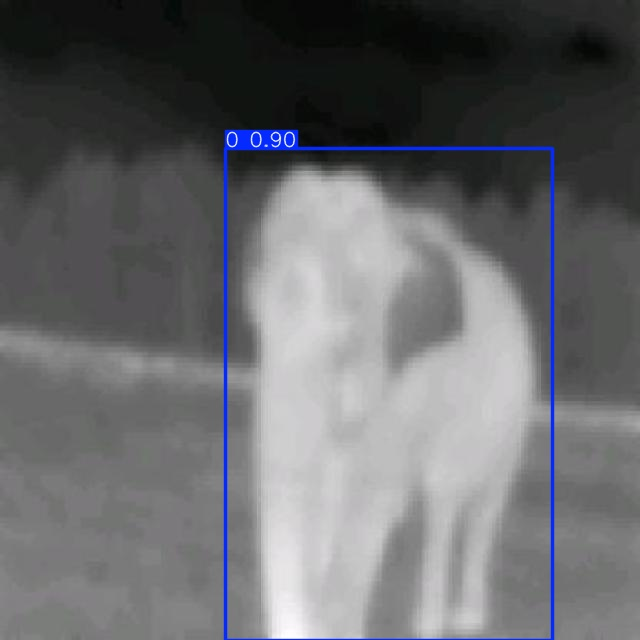

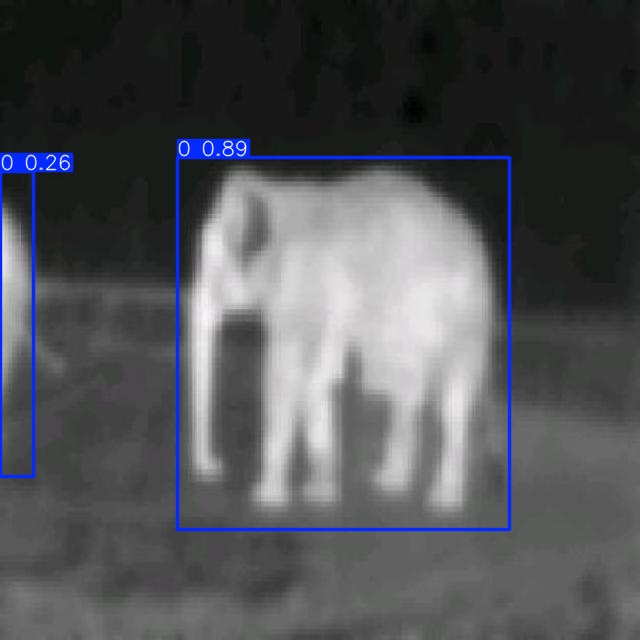

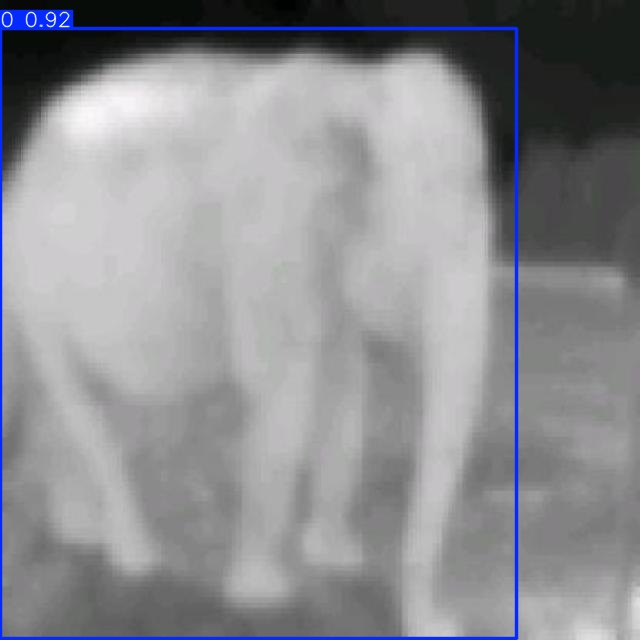

In [7]:

import zipfile, os, glob
from ultralytics import YOLO
from IPython.display import Image, display

# --- Step 1: Paths ---
zip_path = "/content/Elephant_YOLOv8_thermal_elephant_v1.zip"   # your trained model zip
extract_path = "/content/Elephant_YOLOv8_extracted"             # where to extract
test_images = "/content/Elephant_YOLOv8_Cleaned"                # test dataset

# --- Step 2: Extract zip only if folder doesn't exist ---
if not os.path.exists(extract_path):
    print("📦 Extracting model zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Extracted YOLOv8 results to: {extract_path}")
else:
    print(f"⚡ Model already extracted at: {extract_path}")

# --- Step 3: Find model weights ---
best_model_path, last_model_path = None, None
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith("best.pt"):
            best_model_path = os.path.join(root, file)
        elif file.endswith("last.pt"):
            last_model_path = os.path.join(root, file)

# Pick best.pt if available, else last.pt
model_path = best_model_path or last_model_path
if model_path is None:
    raise FileNotFoundError("❌ No YOLOv8 weights (.pt) found in extracted folder!")

print(f"✅ Using model weights: {model_path}")

# --- Step 4: Load YOLOv8 model ---
model = YOLO(model_path)

# --- Step 5: Run inference ---
results = model.predict(
    source=test_images,   # test dataset images
    save=True,
    conf=0.25
)

print("✅ Inference complete! Results saved in runs/detect/predict")

# --- Step 6: Display some results ---
pred_images = glob.glob("runs/detect/predict/*.jpg")[:5]
if pred_images:
    for img_path in pred_images:
        display(Image(filename=img_path))
else:
    print("⚠️ No prediction images found. Check test dataset path.")


In [ ]:
import serial
import time

# --- Step 1: Configure Serial Port ---
# Replace '/dev/ttyUSB0' with your GSM module port
gsm_port = '/dev/ttyUSB0'   # e.g., COM3 on Windows
baud_rate = 9600

ser = serial.Serial(gsm_port, baud_rate, timeout=1)
time.sleep(2)  # wait for GSM module to initialize

# --- Step 2: Function to send SMS ---
def send_sms(number, message):
    try:
        ser.write(b'AT\r')  # check communication
        time.sleep(1)
        ser.write(b'AT+CMGF=1\r')  # set text mode
        time.sleep(1)
        ser.write(f'AT+CMGS="{number}"\r'.encode())
        time.sleep(1)
        ser.write(message.encode() + b'\x1A')  # CTRL+Z to send
        time.sleep(3)
        print(f"✅ SMS sent to {number}: {message}")
    except Exception as e:
        print("❌ Error sending SMS:", e)

# --- Step 3: Use GSM alert if elephant detected ---
# List of authorities' numbers
alert_numbers = ["+918056420717", "+918015985601"]

alert_message = "⚠️ Elephant detected in thermal area. Immediate action required!"

for number in alert_numbers:
    send_sms(number, alert_message)

# --- Step 4: Close serial port ---
ser.close()
